In [1]:
#libraries
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline

import numpy as np

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, Reshape
from keras.layers import Embedding, Dropout, Concatenate, Input
from keras.models import Model, Sequential
from keras.utils import to_categorical

from keras.engine.topology import Layer
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import warnings


Using TensorFlow backend.


In [2]:
img_size = 256
batch_size = 16
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2

#Measure of success
def kappa(y_true, y_pred):
    y_true = np.argmax(y_true, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [3]:
breeds = pd.read_csv('../all/breed_labels.csv')
colors = pd.read_csv('../all/color_labels.csv')
states = pd.read_csv('../all/state_labels.csv')
train = pd.read_csv('../all/train.csv')
test = pd.read_csv('../all/test/test.csv')

In [4]:
pet_ids = train['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

### Get 256 image features for each pet

Don't need to run the model now. Directly load the csv features. Later, we could use a different pre-trained model or even re-train few layers.


In [5]:
train_feats = pd.read_csv('../all/train_img_features.csv')
test_feats = pd.read_csv('../all/test/test_img_features.csv')

In [6]:
print(train_feats.shape)
print(test_feats.shape)


(14993, 257)
(3948, 257)


#### Merge the image features with the categorical and numerical embeddings

In [7]:
train = train.merge(train_feats, left_on='PetID', right_on='Unnamed: 0', how='outer')
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,246,247,248,249,250,251,252,253,254,255
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.787699,0.176625,0.575706,1.088627,0.439557,0.520460,1.547071,0.832572,0.599095,0.763349
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0.628260,0.686865,0.563999,0.968190,1.070276,1.545739,0.894411,0.838595,0.468236,0.916672
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.579116,0.557624,1.131405,0.720514,1.496672,0.870955,1.289682,1.184461,0.465113,0.892826
3,1,Miko,4,307,0,2,1,2,0,2,...,1.295853,0.326143,0.291668,1.608086,1.119176,1.470888,0.591445,0.832753,0.483021,1.134128
4,1,Hunter,1,307,0,1,1,0,0,2,...,1.092663,0.669893,0.395784,0.886075,1.219730,1.033964,1.065685,0.304053,0.438069,0.676818


### Encode tabular features

In [8]:
train_label = train.AdoptionSpeed
#We drop name because it creates a huge embedding vector and we know that name is not very useful anyway
train = train.drop(['AdoptionSpeed', 'Name', 'Description', 'PetID', 'Unnamed: 0', 'RescuerID'], axis=1)

In [9]:
#create train and test set
X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=TEST_SPLIT, random_state=9)

#Turn labels into n dimensional vectors for loss calculation
y_train = to_categorical(y_train, num_classes=None)
y_test = to_categorical(y_test, num_classes=None)

In [10]:
categorical_vars = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
        'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
        'Sterilized', 'Health', 'State']
numerical_vars = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']

In [11]:
def preproc(X_train, X_test, embed_cols, num_cols):

    input_list_train = []
    input_list_test = []
    m= MinMaxScaler()
        
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        m.fit(X_train[c].map(val_map).values.reshape(-1, 1))
        input_list_train.append(m.transform(X_train[c].map(val_map).values.reshape(-1, 1)))
        
        m.fit(X_test[c].map(val_map).fillna(0).values.reshape(-1, 1))
        input_list_test.append(m.transform(X_test[c].map(val_map).fillna(0).values.reshape(-1, 1)))
        
    #the numerical columns
    m.fit(X_train[num_cols].values)
    input_list_train.append(m.transform(X_train[num_cols].values))
    
    m.fit(X_test[num_cols].values)
    input_list_test.append(m.transform(X_test[num_cols].values))
    
    #img data
    input_list_train.append(X_train.iloc[:, 19:].as_matrix())
    input_list_test.append(X_test.iloc[:, 19:].as_matrix())
    
    return input_list_train, input_list_test


#Creating a Embedding model for categorical variables using the fast.ai approach
def createModel(data, categorical_vars, numerical_vars):
    embeddings = []
    inputs = []
    for categorical_var in categorical_vars :
        i = Input(shape=(1,))
        model = Sequential()
        no_of_unique_cat  = data[categorical_var].nunique()
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
        embedding_size = int(embedding_size)
        vocab  = no_of_unique_cat+1
        embedding = Embedding(vocab ,embedding_size, input_length = 1 )(i)
        embedding = Reshape(target_shape=(embedding_size,))(embedding)
        embeddings.append( embedding )
        inputs.append(i)
        
    input_numeric = Input(shape=(len(numerical_vars),))
    embedding_numeric = Dense(16)(input_numeric) 
    
    
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    
    x = Concatenate()(embeddings)
    x = Dense(50, activation='relu')(x)
    x = Dropout(.25)(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(.25)(x)
    
    #hardcoded for now
    image_input = Input(shape=(256,))
    inputs.append(image_input)
    
    y = Dense(80, activation='relu')(image_input)    
    y = Dense(40, activation='relu')(y)
    y = Dropout(.25)(y)
    
    z = Concatenate()([x, y])
    
    z = Dense(20, activation='relu')(z)
    
    output = Dense(5, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')
    return model

In [12]:
warnings.filterwarnings('ignore')
X_train, X_test = preproc(X_train, X_test, categorical_vars, numerical_vars)


In [13]:
model = createModel(train, categorical_vars, numerical_vars)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

### Now, we will train our model

In [14]:
filepath="../checkpoints/weights_image_categorical.hdf6"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopped = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=10, verbose=0, mode='max')
#callbacks_list = [checkpoint, earlystopped]
callbacks_list = [checkpoint]



In [15]:
hist = model.fit(X_train, y_train, batch_size=64 ,epochs=100, validation_split=VALIDATION_SPLIT, 
                 shuffle=True, callbacks=callbacks_list)

Train on 9595 samples, validate on 2399 samples
Epoch 1/100
9595/9595 [==============================] - 1s 122us/step - loss: 1.4824 - acc: 0.2690 - val_loss: 1.4542 - val_acc: 0.3064

Epoch 00001: val_acc improved from -inf to 0.30638, saving model to ../checkpoints/weights_image_categorical.hdf6
Epoch 2/100
9595/9595 [==============================] - 0s 45us/step - loss: 1.4505 - acc: 0.3036 - val_loss: 1.4345 - val_acc: 0.3185

Epoch 00002: val_acc improved from 0.30638 to 0.31847, saving model to ../checkpoints/weights_image_categorical.hdf6
Epoch 3/100
9595/9595 [==============================] - 0s 45us/step - loss: 1.4322 - acc: 0.3251 - val_loss: 1.4026 - val_acc: 0.3685

Epoch 00003: val_acc improved from 0.31847 to 0.36849, saving model to ../checkpoints/weights_image_categorical.hdf6
Epoch 4/100
9595/9595 [==============================] - 0s 47us/step - loss: 1.4085 - acc: 0.3534 - val_loss: 1.3819 - val_acc: 0.3814

Epoch 00004: val_acc improved from 0.36849 to 0.38141, 

Epoch 40/100
9595/9595 [==============================] - 0s 46us/step - loss: 1.2858 - acc: 0.4344 - val_loss: 1.3535 - val_acc: 0.4056

Epoch 00040: val_acc did not improve from 0.42018
Epoch 41/100
9595/9595 [==============================] - 0s 46us/step - loss: 1.2839 - acc: 0.4373 - val_loss: 1.3496 - val_acc: 0.4148

Epoch 00041: val_acc did not improve from 0.42018
Epoch 42/100
9595/9595 [==============================] - 0s 46us/step - loss: 1.2844 - acc: 0.4355 - val_loss: 1.3522 - val_acc: 0.4035

Epoch 00042: val_acc did not improve from 0.42018
Epoch 43/100
9595/9595 [==============================] - 0s 46us/step - loss: 1.2790 - acc: 0.4380 - val_loss: 1.3574 - val_acc: 0.4068

Epoch 00043: val_acc did not improve from 0.42018
Epoch 44/100
9595/9595 [==============================] - 0s 46us/step - loss: 1.2741 - acc: 0.4479 - val_loss: 1.3611 - val_acc: 0.4127

Epoch 00044: val_acc did not improve from 0.42018
Epoch 45/100
9595/9595 [==============================] - 0s


Epoch 00083: val_acc did not improve from 0.42018
Epoch 84/100
9595/9595 [==============================] - 0s 46us/step - loss: 1.1554 - acc: 0.5022 - val_loss: 1.4452 - val_acc: 0.3831

Epoch 00084: val_acc did not improve from 0.42018
Epoch 85/100
9595/9595 [==============================] - 0s 45us/step - loss: 1.1481 - acc: 0.5067 - val_loss: 1.4885 - val_acc: 0.3810

Epoch 00085: val_acc did not improve from 0.42018
Epoch 86/100
9595/9595 [==============================] - 0s 46us/step - loss: 1.1466 - acc: 0.5093 - val_loss: 1.4714 - val_acc: 0.3818

Epoch 00086: val_acc did not improve from 0.42018
Epoch 87/100
9595/9595 [==============================] - 0s 45us/step - loss: 1.1435 - acc: 0.5042 - val_loss: 1.5128 - val_acc: 0.3706

Epoch 00087: val_acc did not improve from 0.42018
Epoch 88/100
9595/9595 [==============================] - 0s 46us/step - loss: 1.1370 - acc: 0.5120 - val_loss: 1.5053 - val_acc: 0.3906

Epoch 00088: val_acc did not improve from 0.42018
Epoch 89/

[]

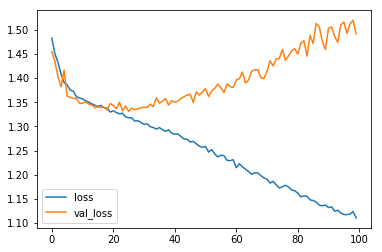

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.plot()


[]

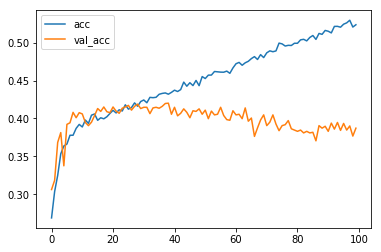

In [17]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.plot()


#### Evaluate our test set and find out Cohen's  quadratic weighte kappa for both Train and Test

In [18]:
model.evaluate(X_test, y_test)

2999/2999 [==============================] - 0s 29us/step


[1.5388475499100667, 0.37312437477172233]

In [19]:
test_pred = model.predict(X_test)
kappa(y_test, test_pred)

0.2697544056508283

In [20]:
train_pred = model.predict(X_train)
kappa(y_train, train_pred)

0.5109110593795546

#### Load out best model and check metrics

In [21]:
model.load_weights('../checkpoints/weights_image_categorical.hdf6')

test_pred = model.predict(X_test)
kappa(y_test, test_pred)

0.285393359014362

In [22]:
train_pred = model.predict(X_train)
kappa(y_train, train_pred)

0.41397791687040897